In [1]:
from __future__ import print_function, division, absolute_import
from six.moves import cPickle as pickle

In [2]:
import os, time

import numpy as np

import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

### Loading data

In [4]:
image_size = 28
pixel_depth = 255
data_root = 'data'

In [5]:
pickle_file  = os.path.join(data_root, 'notMNIST.pickle')
keys = ["{0}_{1}".format(t,x) for t in ["train","test"] for x in "Xy"]+["labels_dict"]
with open(pickle_file, 'rb') as f:
    pi = pickle.load(f)
    for k in keys:
        globals()[k] = pi[k]
print(train_X.shape, test_X.shape)

(529114, 784) (18724, 784)


In [6]:
nclasses = len(labels_dict)
labels_dict

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9}

In [7]:
def to_onehot(labels, nclasses):
    onehot = np.zeros(shape=(len(labels), nclasses))
    for i, label in enumerate(labels):
        onehot[i, int(label)] = 1
    return onehot

test_y = to_onehot(test_y, nclasses)

In [8]:
def generate_batch(batch_size=10):
    global train_X, train_y, labels_dict
    j = 0
    while 1:
        i = j
        if i+batch_size < len(train_X):
            j = i + batch_size
            raw_labels = train_y[i:i+batch_size]
            yield train_X[i:i+batch_size], to_onehot(raw_labels.flatten(), len(labels_dict))
        else:
            j = 0
            raw_labels = np.concatenate((train_y[i:], train_y[0:batch_size-(len(train_y)-i)]))
            yield np.concatenate((train_X[i:], train_X[0:batch_size-(len(train_X)-i)])),\
                    to_onehot(raw_labels.flatten(), len(labels_dict))
        

### L2 Regularization
<img src="https://raw.githubusercontent.com/ritchieng/machine-learning-nanodegree/master/deep_learning/deep_neural_nets/dnn12.png">

In [9]:
epochs = 60000
learning_rate = 0.1
batch_size = 1000
beta = 0.01

In [10]:
graph = tf.Graph()

with graph.as_default():
    with tf.name_scope("inputs"):
        train_inputs = tf.placeholder(tf.float32, shape=[batch_size, image_size*image_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, nclasses])

        W1 = tf.Variable(tf.random_normal(shape=[image_size*image_size, image_size*image_size], stddev=0.1))
        b1 = tf.Variable(tf.zeros(shape=[image_size*image_size]))

        h1 = tf.nn.relu(
            tf.add(tf.matmul(train_inputs, W1), b1))
        with tf.name_scope("dropout"):
            h1_dropout = tf.nn.dropout(h1, 0.5)
        
        W2 = tf.Variable(tf.random_normal(shape=[image_size*image_size, nclasses], stddev=0.1))
        b2 = tf.Variable(tf.zeros(shape=[nclasses]))
        
        logits = tf.add(tf.matmul(h1_dropout,W2), b2)

    with tf.name_scope("Loss"):
        cross_entropy_ = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=train_labels))
        
    with tf.name_scope("regularization"):
        regularizer = tf.nn.l2_loss(cross_entropy_)
        cross_entropy = tf.reduce_mean(tf.add(cross_entropy_, beta*regularizer))
        
    with tf.name_scope("Optimizer"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        
    with tf.name_scope("Predictions"):
        test_inputs = tf.placeholder(tf.float32, shape=[None, image_size*image_size])
        test_labels = tf.placeholder(tf.int32, shape=[None, nclasses])
        h1_test = tf.nn.relu(
            tf.add(tf.matmul(test_inputs, W1), b1))
        test_logits = tf.add(tf.matmul(h1_test, W2), b2, name="test_logits")
        prediction_probs = tf.nn.softmax(test_logits)
        predictions = tf.argmax(prediction_probs, 1)
        
    with tf.name_scope("Accuracy"):
        target = tf.argmax(test_labels, 1)
        correct = tf.equal(predictions, target)
        accuracy = tf.reduce_mean(tf.cast(correct, "float"))
    init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [11]:
start = time.time()
accuracies = dict()
losses = dict()

batches = generate_batch(batch_size=batch_size)
with tf.Session(graph=graph) as sess:
    with tf.device("/gpu"):
        init.run()
        print("Variables initialized")
        average_loss = 0
        for e in range(epochs+1):
            batch_X, batch_y = batches.__next__()  # train on a single batch to check overfitting
            feed_dict = {train_inputs:batch_X, train_labels:batch_y}
            _, loss = sess.run([optimizer, cross_entropy], feed_dict=feed_dict)
            average_loss += np.mean(loss)
            if e%1000 == 0:
                print("Epoch {0}\nCross-entropy loss: {1}".format(e,average_loss/1000 if e>0 else average_loss))
                
                losses[e] = average_loss
                average_loss = 0
                accuracy_ = sess.run([accuracy], feed_dict={test_inputs:test_X, test_labels:test_y})
                accuracy_ = np.mean(accuracy_)
                accuracies[e] = accuracy_
                print("Accuracy:{0}".format(accuracy_))
                print("~"*40)
print("Took: {}".format(time.time()-start))

Variables initialized
Epoch 0
Cross-entropy loss: 11.942103385925293
Accuracy:0.42912837862968445
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1000
Cross-entropy loss: 0.8298839880228043
Accuracy:0.9201025366783142
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2000
Cross-entropy loss: 0.5617737274765968
Accuracy:0.9268853068351746
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3000
Cross-entropy loss: 0.5303073349297047
Accuracy:0.9308374524116516
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 4000
Cross-entropy loss: 0.5127404749393463
Accuracy:0.9303567409515381
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 5000
Cross-entropy loss: 0.4975860996544361
Accuracy:0.9343088865280151
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 6000
Cross-entropy loss: 0.4865035832822323
Accuracy:0.9379405975341797
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 7000
Cross-entropy loss: 0.4779286648631096
Accuracy:0.9389553666114807
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 8000
Cross-entropy los

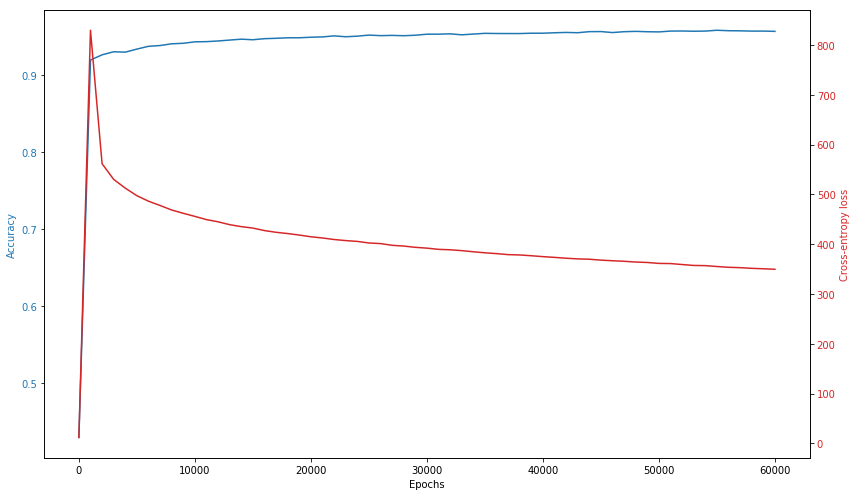

In [12]:
fig, ax1 = plt.subplots(figsize=(12,7))
xticks = sorted(accuracies.keys())
data1 = [accuracies[i] for i in xticks]
data2 = [losses[i] for i in xticks]

color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(xticks, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Cross-entropy loss', color=color)
ax2.plot(xticks, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped